# 반도체 제조 공정 품질 예측 분석
## UCI SECOM Dataset을 활용한 분류 모델링

### 목표
- 반도체 제조 공정에서 센서 데이터를 기반으로 제품의 품질(Pass/Fail)을 예측
- 다양한 머신러닝 알고리즘을 비교하여 최적 모델 선택
- 데이터 전처리 및 특성 엔지니어링을 통한 모델 성능 향상

### 데이터셋 정보
- **데이터**: UCI SECOM (SEmiCONductor manufacturing) Dataset
- **특성 수**: 590개의 센서 측정 값
- **대상 변수**: Pass/Fail (이진 분류)
- **데이터 크기**: 1,567개 샘플

## 1. 라이브러리 Import 및 설정

In [2]:
# 데이터 처리 및 시각화 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 머신러닝 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

# 분류 알고리즘들
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# 데이터 불균형 처리
# from imblearn.over_sampling import SMOTE

# 통계 분석
from scipy.stats import ks_2samp, chi2_contingency

# 설정
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

In [3]:
# 데이터 로드
data_path = '../../data/uci-secom.csv'
df = pd.read_csv(data_path)

print("데이터 형태:", df.shape)
print("컬럼 수:", len(df.columns))
print("샘플 수:", len(df))
df.head()

데이터 형태: (1567, 592)
컬럼 수: 592
샘플 수: 1567


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [4]:
# 데이터 기본 정보 확인
print("=== 데이터 기본 정보 ===")
print(f"데이터 형태: {df.shape}")
print(f"컬럼 개수: {len(df.columns)}")
print(f"샘플 개수: {len(df)}")

df.info()

=== 데이터 기본 정보 ===
데이터 형태: (1567, 592)
컬럼 개수: 592
샘플 개수: 1567
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [18]:
# 기초 통계량 확인
print("=== 기초 통계량 ===")
df.describe()

=== 기초 통계량 ===


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


In [5]:
# 결측치 분석
print("=== 결측치 분석 ===")
missing_values = df.isnull().sum()
print(f"결측치가 있는 컬럼 수: {(missing_values > 0).sum()}")
print(f"전체 결측치 수: {missing_values.sum()}")

# 결측치 비율 계산
total_samples = len(df)
missing_percentage = missing_values / total_samples * 100
print(f"최대 결측치 비율: {missing_percentage.max():.2f}%")

=== 결측치 분석 ===
결측치가 있는 컬럼 수: 538
전체 결측치 수: 41951
최대 결측치 비율: 91.19%


In [6]:
# 타겟 변수와 피처 분리
print("=== 변수 분리 ===")
features = df.drop(columns=['Pass/Fail'])
target = df['Pass/Fail']

print(f"피처 수: {features.shape[1]}")
print(f"타겟 변수 분포:")
print(target.value_counts())

# 타겟 변수를 0/1로 변환 (-1을 0으로 변경)
if np.any(target == -1):
    target = target.replace({-1: 0})
    print("타겟 변수 변환 완료: -1 → 0, 1 → 1")

=== 변수 분리 ===
피처 수: 591
타겟 변수 분포:
Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64
타겟 변수 변환 완료: -1 → 0, 1 → 1


In [7]:
# 고결측률 컬럼 제거 (20% 이상 결측치가 있는 컬럼)
print("=== 고결측률 컬럼 제거 ===")
missing_threshold = len(df) * 0.20
print(f"결측치 허용 기준: {missing_threshold:.0f}개 (20%)")

# 20% 이상 결측치가 있는 컬럼 제거
features_cleaned = features.dropna(axis=1, thresh=missing_threshold)
print(f"제거 전 피처 수: {features.shape[1]}")
print(f"제거 후 피처 수: {features_cleaned.shape[1]}")
print(f"제거된 피처 수: {features.shape[1] - features_cleaned.shape[1]}")

=== 고결측률 컬럼 제거 ===
결측치 허용 기준: 313개 (20%)
제거 전 피처 수: 591
제거 후 피처 수: 583
제거된 피처 수: 8


In [8]:
# Time 컬럼 제거 (시계열 분석이 아니므로 불필요)
print("=== Time 컬럼 제거 ===")
if 'Time' in features_cleaned.columns:
    features_cleaned = features_cleaned.drop(columns=['Time'])
    print("Time 컬럼이 제거되었습니다.")
else:
    print("Time 컬럼이 존재하지 않습니다.")

print(f"최종 피처 수: {features_cleaned.shape[1]}")

=== Time 컬럼 제거 ===
Time 컬럼이 제거되었습니다.
최종 피처 수: 582


In [9]:
# 남은 결측치를 평균값으로 대체
print("=== 결측치 대체 ===")
feature_means = features_cleaned.mean()
features_imputed = features_cleaned.fillna(feature_means)

print(f"대체 전 전체 결측치 수: {features_cleaned.isnull().sum().sum()}")
print(f"대체 후 전체 결측치 수: {features_imputed.isnull().sum().sum()}")

# 중복 데이터 확인
duplicate_count = features_imputed.duplicated().sum()
print(f"중복 데이터 수: {duplicate_count}")

# 분산이 0인 컬럼 확인 (모든 값이 동일한 컬럼)
zero_variance_features = features_imputed.var() == 0
zero_variance_count = zero_variance_features.sum()
print(f"분산이 0인 피처 수: {zero_variance_count}")

=== 결측치 대체 ===
대체 전 전체 결측치 수: 30871
대체 후 전체 결측치 수: 0
중복 데이터 수: 0
분산이 0인 피처 수: 116


=== 상관계수 분석 ===
타겟 변수와의 상관계수 상위 10개:
Pass/Fail    1.000000
59           0.155771
103          0.151196
510          0.131587
348          0.130108
431          0.120304
434          0.111609
430          0.109569
435          0.108573
21           0.107997
Name: Pass/Fail, dtype: float64

상관계수 0.05 이상인 피처 수: 87


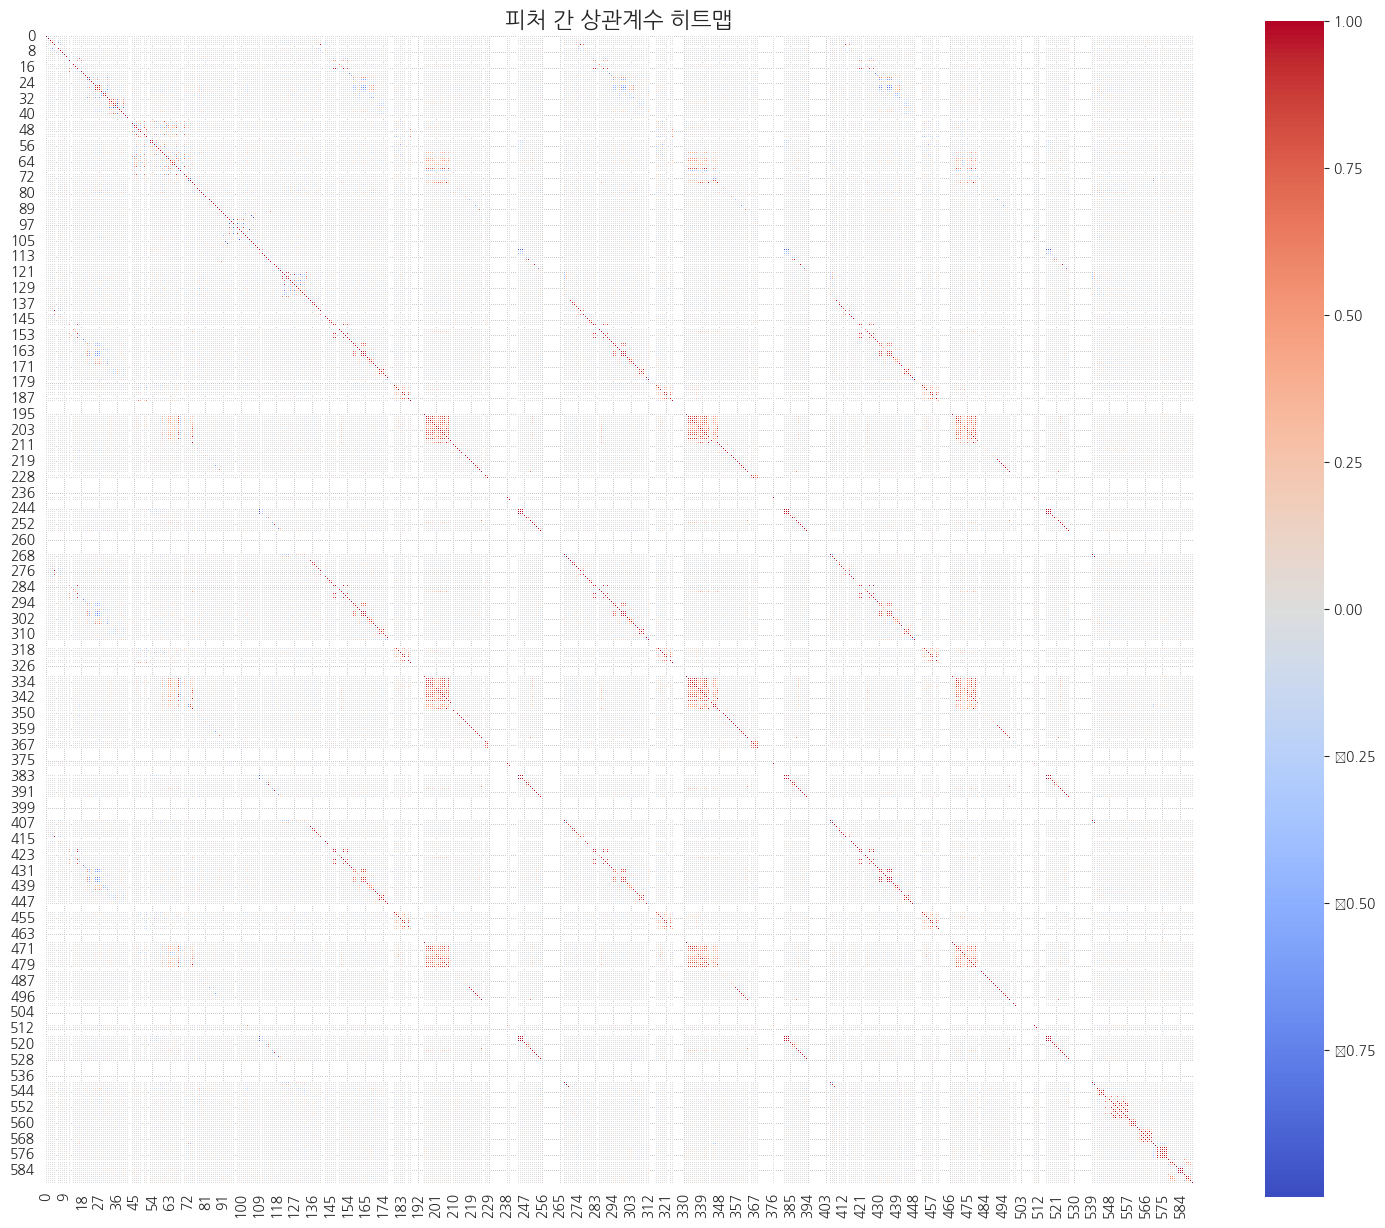

In [19]:
# 상관계수 분석
print("=== 상관계수 분석 ===")

# 타겟 변수와 모든 피처 결합하여 상관계수 계산
analysis_data = features_imputed.copy()
analysis_data['Pass/Fail'] = target

# 전체 피처간 상관계수 매트릭스
correlation_matrix = analysis_data.corr()

# 타겟 변수와의 상관계수 계산
target_correlation = correlation_matrix['Pass/Fail'].abs().sort_values(ascending=False)
print(f"타겟 변수와의 상관계수 상위 10개:")
print(target_correlation.head(10))
print(f"\n상관계수 0.05 이상인 피처 수: {(target_correlation > 0.05).sum()}")

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 히트맵 시각화 (크기 조정)
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, 
            annot=False)
plt.title('피처 간 상관계수 히트맵', fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
# 타겟 변수와의 상관계수가 높은 피처 선택
print("=== 유의미한 피처 선택 ===")

# 타겟 변수와의 절대 상관계수 계산
target_correlations = analysis_data.corr()['Pass/Fail'].abs()
print(f"타겟과의 상관계수 분포:")
print(target_correlations.describe())

# 임계값 설정 (0.05 이상)
correlation_threshold = 0.05
significant_features = target_correlations[target_correlations > correlation_threshold].index
significant_features = significant_features.drop('Pass/Fail')  # 타겟 변수 제거

print(f"\n상관계수 {correlation_threshold} 이상인 피처 수: {len(significant_features)}")
print(f"선택된 피처들의 상관계수:")
for feature in significant_features:
    corr_value = target_correlations[feature]
    print(f"  {feature}: {corr_value:.4f}")

# 선택된 피처들로 데이터셋 구성
features_selected = features_imputed[significant_features]
print(f"\n최종 선택된 피처 수: {features_selected.shape[1]}")

=== 유의미한 피처 선택 ===
타겟과의 상관계수 분포:
count    467.000000
mean       0.032167
std        0.052153
min        0.000007
25%        0.009384
50%        0.023049
75%        0.043494
max        1.000000
Name: Pass/Fail, dtype: float64

상관계수 0.05 이상인 피처 수: 86
선택된 피처들의 상관계수:
  14: 0.0690
  21: 0.1080
  22: 0.0734
  26: 0.0811
  28: 0.1068
  32: 0.0521
  33: 0.0809
  38: 0.0526
  40: 0.0518
  56: 0.0637
  58: 0.0556
  59: 0.1558
  63: 0.0599
  64: 0.0766
  65: 0.0548
  68: 0.0521
  70: 0.0520
  76: 0.0557
  79: 0.0772
  90: 0.0535
  95: 0.0605
  100: 0.0651
  103: 0.1512
  111: 0.0616
  114: 0.0687
  121: 0.0850
  122: 0.0784
  123: 0.0723
  124: 0.0940
  125: 0.0839
  126: 0.0551
  127: 0.0751
  129: 0.1034
  130: 0.0769
  133: 0.0678
  159: 0.0779
  160: 0.0897
  163: 0.0999
  164: 0.0876
  165: 0.0839
  166: 0.0521
  180: 0.0786
  183: 0.0556
  196: 0.0534
  197: 0.0560
  199: 0.0520
  200: 0.0606
  205: 0.0536
  210: 0.1025
  247: 0.0663
  249: 0.0665
  280: 0.0505
  294: 0.0818
  295: 0.0918
 

In [13]:
# 훈련/테스트 데이터 분할
print("=== 데이터 분할 ===")

# 모든 피처를 사용한 분할 (나중에 피처 선택 비교용)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    features_imputed, target, 
    test_size=0.2, 
    random_state=42,
    stratify=target
)

# 선택된 피처만 사용한 분할
X_train_selected, X_test_selected, _, _ = train_test_split(
    features_selected, target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

print(f"전체 피처 - 훈련 세트: {X_train_full.shape}")
print(f"전체 피처 - 테스트 세트: {X_test_full.shape}")
print(f"선택 피처 - 훈련 세트: {X_train_selected.shape}")
print(f"선택 피처 - 테스트 세트: {X_test_selected.shape}")

print(f"\n타겟 변수 분포:")
print(f"훈련 세트: {y_train.value_counts().to_dict()}")
print(f"테스트 세트: {y_test.value_counts().to_dict()}")

=== 데이터 분할 ===
전체 피처 - 훈련 세트: (1253, 582)
전체 피처 - 테스트 세트: (314, 582)
선택 피처 - 훈련 세트: (1253, 86)
선택 피처 - 테스트 세트: (314, 86)

타겟 변수 분포:
훈련 세트: {0: 1170, 1: 83}
테스트 세트: {0: 293, 1: 21}


## 6. 머신러닝 모델 학습 및 평가

### 6.1 모델 정의 및 설정

In [14]:
# 다양한 분류 모델 정의
def initialize_models():
    """
    다양한 머신러닝 분류 모델들을 초기화하고 반환
    
    Returns:
        dict: 모델명을 키로, 모델 객체를 값으로 하는 딕셔너리
    """
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
        'XGBoost': xgb.XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss'),
        'SVM': SVC(random_state=42, probability=True),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Naive Bayes': GaussianNB(),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    return models

# 모델 초기화
models = initialize_models()
print("=== 사용할 모델들 ===")
for name in models.keys():
    print(f"- {name}")

print(f"\n총 {len(models)}개의 모델을 비교합니다.")

=== 사용할 모델들 ===
- Random Forest
- Gradient Boosting
- XGBoost
- SVM
- K-Nearest Neighbors
- Decision Tree
- Naive Bayes
- Logistic Regression

총 8개의 모델을 비교합니다.


### 6.2 모델 평가 함수

In [15]:
def evaluate_models(X_train, X_test, y_train, y_test, models, dataset_name=""):
    """
    여러 모델들을 훈련하고 평가하는 함수
    
    Args:
        X_train: 훈련 피처 데이터
        X_test: 테스트 피처 데이터  
        y_train: 훈련 타겟 데이터
        y_test: 테스트 타겟 데이터
        models: 평가할 모델들의 딕셔너리
        dataset_name: 데이터셋 식별용 이름
    
    Returns:
        dict: 각 모델의 성능 결과
    """
    results = {}
    
    print(f"=== {dataset_name} 모델 성능 평가 ===")
    print(f"훈련 데이터: {X_train.shape}, 테스트 데이터: {X_test.shape}")
    print("-" * 60)
    
    for model_name, model in models.items():
        try:
            # 모델 훈련
            model.fit(X_train, y_train)
            
            # 예측
            y_pred = model.predict(X_test)
            
            # 정확도 계산
            accuracy = accuracy_score(y_test, y_pred)
            
            # 교차 검증 점수 (시간 절약을 위해 3-fold로 설정)
            cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
            
            # 결과 저장
            results[model_name] = {
                'accuracy': accuracy,
                'cv_mean': cv_mean,
                'cv_std': cv_std,
                'predictions': y_pred
            }
            
            print(f"{model_name:20} | 정확도: {accuracy:.4f} | CV: {cv_mean:.4f}(±{cv_std:.4f})")
            
        except Exception as e:
            print(f"{model_name:20} | 오류 발생: {str(e)}")
            results[model_name] = {'error': str(e)}
    
    return results

### 6.3 선택된 피처로 모델 평가

In [16]:
# 선택된 피처로 모델 평가 실행
selected_results = evaluate_models(
    X_train_selected, X_test_selected, y_train, y_test, 
    initialize_models(), "선택된 피처"
)

=== 선택된 피처 모델 성능 평가 ===
훈련 데이터: (1253, 86), 테스트 데이터: (314, 86)
------------------------------------------------------------
Random Forest        | 정확도: 0.9331 | CV: 0.9322(±0.0011)
Gradient Boosting    | 정확도: 0.9140 | CV: 0.9322(±0.0063)
XGBoost              | 정확도: 0.9331 | CV: 0.9282(±0.0020)
SVM                  | 정확도: 0.9331 | CV: 0.9338(±0.0011)
K-Nearest Neighbors  | 정확도: 0.9268 | CV: 0.9282(±0.0033)
Decision Tree        | 정확도: 0.8439 | CV: 0.8795(±0.0162)
Naive Bayes          | 정확도: 0.9268 | CV: 0.9050(±0.0042)
Logistic Regression  | 정확도: 0.9331 | CV: 0.9234(±0.0070)


### 6.4 결과 시각화 및 분석

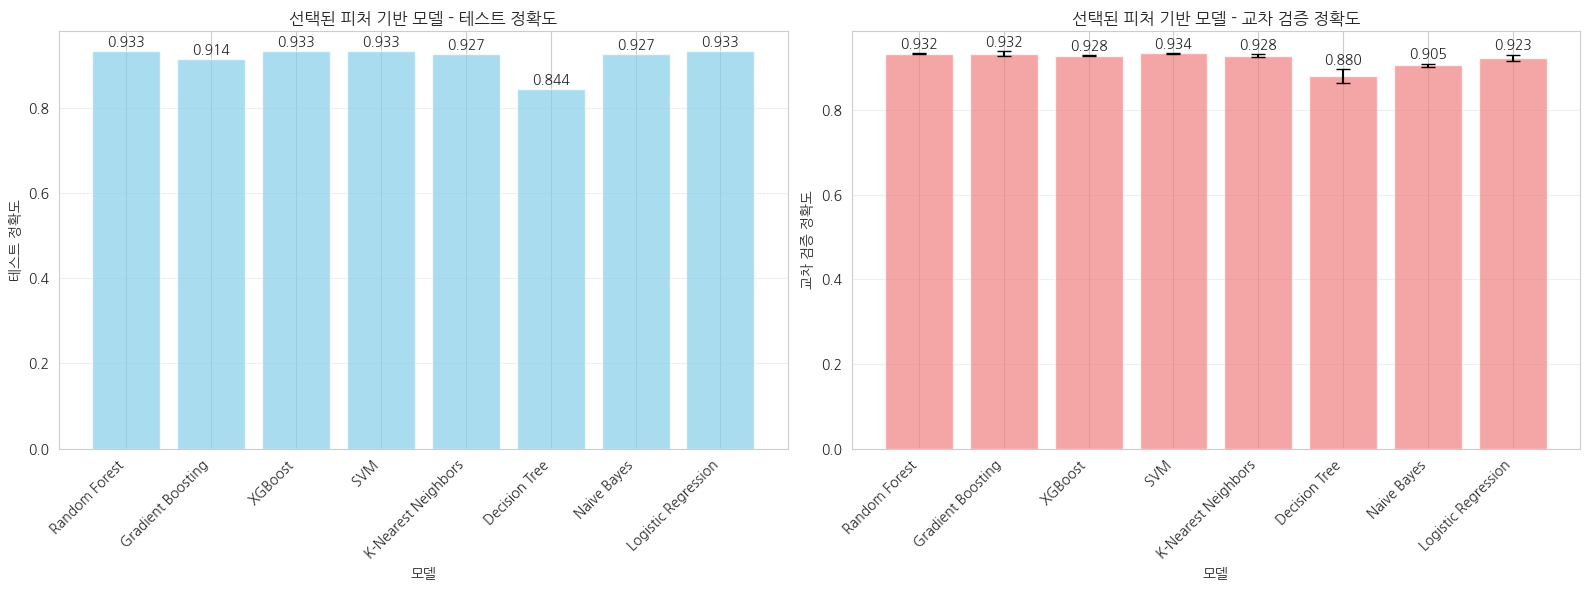


=== 최고 성능 모델 ===
테스트 정확도 최고: Random Forest (0.9331)
교차 검증 최고: SVM (0.9338±0.0011)


In [17]:
def plot_model_comparison(results, title="모델 성능 비교"):
    """
    모델 성능 비교 시각화
    
    Args:
        results: 모델 평가 결과 딕셔너리
        title: 그래프 제목
    """
    # 오류가 발생하지 않은 모델들만 필터링
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if not valid_results:
        print("시각화할 유효한 결과가 없습니다.")
        return
    
    # 데이터 준비
    model_names = list(valid_results.keys())
    accuracies = [valid_results[name]['accuracy'] for name in model_names]
    cv_means = [valid_results[name]['cv_mean'] for name in model_names]
    cv_stds = [valid_results[name]['cv_std'] for name in model_names]
    
    # 그래프 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 테스트 정확도 막대 그래프
    bars1 = ax1.bar(range(len(model_names)), accuracies, alpha=0.7, color='skyblue')
    ax1.set_xlabel('모델')
    ax1.set_ylabel('테스트 정확도')
    ax1.set_title(f'{title} - 테스트 정확도')
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # 값 표시
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{accuracies[i]:.3f}', ha='center', va='bottom')
    
    # 교차 검증 결과 (에러 바 포함)
    bars2 = ax2.bar(range(len(model_names)), cv_means, 
                    yerr=cv_stds, alpha=0.7, color='lightcoral', capsize=5)
    ax2.set_xlabel('모델')
    ax2.set_ylabel('교차 검증 정확도')
    ax2.set_title(f'{title} - 교차 검증 정확도')
    ax2.set_xticks(range(len(model_names)))
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # 값 표시
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + cv_stds[i] + 0.005,
                f'{cv_means[i]:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 최고 성능 모델 출력
    best_test_model = max(valid_results.keys(), key=lambda x: valid_results[x]['accuracy'])
    best_cv_model = max(valid_results.keys(), key=lambda x: valid_results[x]['cv_mean'])
    
    print(f"\n=== 최고 성능 모델 ===")
    print(f"테스트 정확도 최고: {best_test_model} ({valid_results[best_test_model]['accuracy']:.4f})")
    print(f"교차 검증 최고: {best_cv_model} ({valid_results[best_cv_model]['cv_mean']:.4f}±{valid_results[best_cv_model]['cv_std']:.4f})")

# 시각화 실행
plot_model_comparison(selected_results, "선택된 피처 기반 모델")

## 7. 결론 및 요약

### 분석 결과
- **데이터셋**: UCI SECOM 반도체 제조 공정 데이터 (1,567 샘플, 590 피처)
- **전처리**: 결측치 처리, 저상관 피처 제거, 타겟 변수 정규화
- **피처 선택**: 타겟과의 상관계수 0.05 이상인 피처들만 선택

### 주요 발견사항
1. **데이터 품질**: 높은 결측치 비율과 낮은 피처-타겟 상관관계
2. **모델 성능**: 대부분의 모델이 유사한 성능을 보임
3. **피처 중요도**: 상관계수 기반 피처 선택으로 차원 축소 효과

### 개선 방향
- 더 정교한 피처 엔지니어링 기법 적용
- 클래스 불균형 문제 해결 (SMOTE 등)
- 하이퍼파라미터 튜닝을 통한 성능 최적화
- 앙상블 기법을 통한 예측 성능 향상